In [1]:
import numpy as np
import numba
from numba import jit, prange
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Agent Initialization and Tax Calculation
@jit(nopython=True)
def initialize_agents(num_agents):
    agents = np.zeros(num_agents, dtype=np.float32)
    
    n_poor = int(0.5 * num_agents)
    n_middle = int(0.4 * num_agents)
    n_rich = num_agents - n_poor - n_middle
    
    agents[:n_poor] = np.random.uniform(0.1, 3, n_poor)
    agents[n_poor:n_poor+n_middle] = np.random.uniform(3, 12, n_middle)
    agents[n_poor+n_middle:] = np.random.uniform(12, 50, n_rich)
    
    np.random.shuffle(agents)
    return agents

@jit(nopython=True)
def calculate_tax(wealth):
    slabs = np.array([3, 6, 9, 12, 15], dtype=np.float32)
    rates = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.3], dtype=np.float32)
    
    tax = 0.0
    for i in range(len(slabs)):
        if wealth <= slabs[i]:
            tax += rates[i] * (wealth - (slabs[i-1] if i > 0 else 0))
            break
        else:
            tax += rates[i] * (slabs[i] - (slabs[i-1] if i > 0 else 0))
    
    if wealth > slabs[-1]:
        tax += rates[-1] * (wealth - slabs[-1])
    
    return tax

In [3]:
# Cell 3: Trade Probability and Agent Update Functions
@jit(nopython=True)
def calculate_trade_prob(agent1_wealth, agent2_wealth):
    return np.exp(-np.abs(agent1_wealth - agent2_wealth))

@jit(nopython=True)
def initialize_trade_probabilities(agents):
    num_agents = len(agents)
    trade_probs = np.zeros((num_agents, num_agents), dtype=np.float32)
    for i in range(num_agents):
        for j in range(i + 1, num_agents):
            prob = calculate_trade_prob(agents[i], agents[j])
            trade_probs[i, j] = prob
            trade_probs[j, i] = prob
    return trade_probs

@jit(nopython=True)
def roulette_wheel_selection(probs):
    r = np.random.random()
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if r <= cum_prob:
            return i
    return len(probs) - 1

@jit(nopython=True)
def update_agents(agents, trade_probs):
    num_agents = len(agents)
    agent1_index = np.random.randint(0, num_agents)
    agent2_index = roulette_wheel_selection(trade_probs[agent1_index])
    
    transaction_amount = 0.1 * (agents[agent1_index] * agents[agent2_index]) / (agents[agent1_index] + agents[agent2_index])
    agents[agent1_index] -= transaction_amount
    agents[agent2_index] += transaction_amount
    
    for i in range(num_agents):
        if i != agent1_index:
            prob = calculate_trade_prob(agents[agent1_index], agents[i])
            trade_probs[agent1_index, i] = prob
            trade_probs[i, agent1_index] = prob
        if i != agent2_index:
            prob = calculate_trade_prob(agents[agent2_index], agents[i])
            trade_probs[agent2_index, i] = prob
            trade_probs[i, agent2_index] = prob

@jit(nopython=True)
def business_venture(agents, venture_probability):
    num_agents = len(agents)
    for i in range(num_agents):
        if np.random.random() < venture_probability:
            # 40% chance of success
            if np.random.random() < 0.4:
                # Success: gain 20% of current wealth
                agents[i] *= 1.2
            else:
                # Failure: lose 20% of current wealth
                agents[i] *= 0.8
    return agents

In [16]:
# Cell 4: Simulation Function
@jit(nopython=True)
def run_simulation(num_agents, num_years, num_time_steps, venture_probability):
    agents = initialize_agents(num_agents)
    trade_probs = initialize_trade_probabilities(agents)
    
    gini_indices = np.zeros(num_years + 1, dtype=np.float32)
    gini_indices[0] = gini_coefficient(agents)
    
    rich_index = np.argmax(agents)
    poor_index = np.argmin(agents)
    middle_index = np.argsort(agents)[num_agents // 2]
    
    rich_wealth = np.zeros(num_years + 1, dtype=np.float32)
    middle_wealth = np.zeros(num_years + 1, dtype=np.float32)
    poor_wealth = np.zeros(num_years + 1, dtype=np.float32)

    mean_wealth = np.zeros(num_years + 1, dtype=np.float32)
    median_wealth = np.zeros(num_years + 1, dtype=np.float32)
    std_dev_wealth = np.zeros(num_years + 1, dtype=np.float32)
    
    rich_wealth[0] = agents[rich_index]
    middle_wealth[0] = agents[middle_index]
    poor_wealth[0] = agents[poor_index]
    
    total_wealth = np.sum(agents)
    wealth_conservation_errors = np.zeros(num_years)  # Array to store wealth conservation errors
    gini_errors = np.zeros(num_years)  # Array to store Gini coefficient errors
    
    for year in range(num_years+1):
        agents = business_venture(agents, venture_probability)

        for step in range(num_time_steps):
            update_agents(agents, trade_probs)
        
        # Deduct tax
        total_tax = 0.0
        for i in range(num_agents):
            tax = calculate_tax(agents[i])
            agents[i] -= tax
            total_tax += tax
        
        # Redistribute tax
        redistribution = total_tax / num_agents
        agents += redistribution
        
        # Annual updates
        gini_indices[year+1] = gini_coefficient(agents)
        rich_wealth[year+1] = agents[rich_index]
        middle_wealth[year+1] = agents[middle_index]
        poor_wealth[year+1] = agents[poor_index]

        mean_wealth[year+1] = np.mean(agents)
        median_wealth[year+1] = np.median(agents)
        std_dev_wealth[year+1] = np.std(agents)
            
            # Check for wealth conservation
        current_total_wealth = np.sum(agents)
        wealth_conservation_errors[year] = np.abs(total_wealth - current_total_wealth)  # Calculate error
        if not np.isclose(total_wealth, current_total_wealth, rtol=1e-1):
            print("Warning: Total wealth changed in year", year+1)
            print("Initial:", total_wealth, "Current:", current_total_wealth)
            
        # Calculate Gini coefficient error
        gini_errors[year] = np.abs(gini_indices[year+1] - gini_indices[year]) if year > 0 else 0
            
        # Print wealth distribution statistics
        print("Year:", year+1, "Min wealth:", np.min(agents), "Max wealth:", np.max(agents), "Mean wealth:", np.mean(agents))
            
    
    return agents, gini_indices, rich_wealth, middle_wealth, poor_wealth, wealth_conservation_errors, gini_errors, median_wealth, std_dev_wealth

@jit(nopython=True)
def gini_coefficient(wealths):
    sorted_wealths = np.sort(wealths)
    n = len(sorted_wealths)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * sorted_wealths)) / (n * np.sum(sorted_wealths))

In [17]:
# Cell 5: Run Simulation
# Simulation parameters
num_agents = 1000
num_years = 50
num_time_steps = 10000  #per year
venture_probability = 0.4 #percentage of people starting a business

# Run the simulation
final_wealths, gini_indices, rich_wealth, middle_wealth, poor_wealth, wealth_conservation_errors, gini_errors, median_wealth, std_dev_wealth = run_simulation(num_agents, num_years, num_time_steps, venture_probability)

print(f"Final Gini coefficient: {gini_indices[-1]:.4f}")

Year: 1 Min wealth: 0.8778561353683472 Max wealth: 46.389122009277344 Mean wealth: 6.6620888671875
Year: 2 Min wealth: 0.9377135634422302 Max wealth: 41.34066390991211 Mean wealth: 6.4874375
Year: 3 Min wealth: 1.0273661613464355 Max wealth: 37.456058502197266 Mean wealth: 6.39260888671875
Year: 4 Min wealth: 0.938865602016449 Max wealth: 36.78495407104492 Mean wealth: 6.28754345703125
Initial: 6797.86767578125 Current: 6170.7294921875
Year: 5 Min wealth: 0.9369457364082336 Max wealth: 38.34621047973633 Mean wealth: 6.1707294921875
Initial: 6797.86767578125 Current: 6094.3427734375
Year: 6 Min wealth: 0.9075911641120911 Max wealth: 36.34972381591797 Mean wealth: 6.0943427734375
Initial: 6797.86767578125 Current: 5968.3212890625
Year: 7 Min wealth: 0.8573051691055298 Max wealth: 35.93780517578125 Mean wealth: 5.9683212890625
Initial: 6797.86767578125 Current: 5903.50146484375
Year: 8 Min wealth: 0.8503438234329224 Max wealth: 35.794986724853516 Mean wealth: 5.90350146484375
Initial: 679

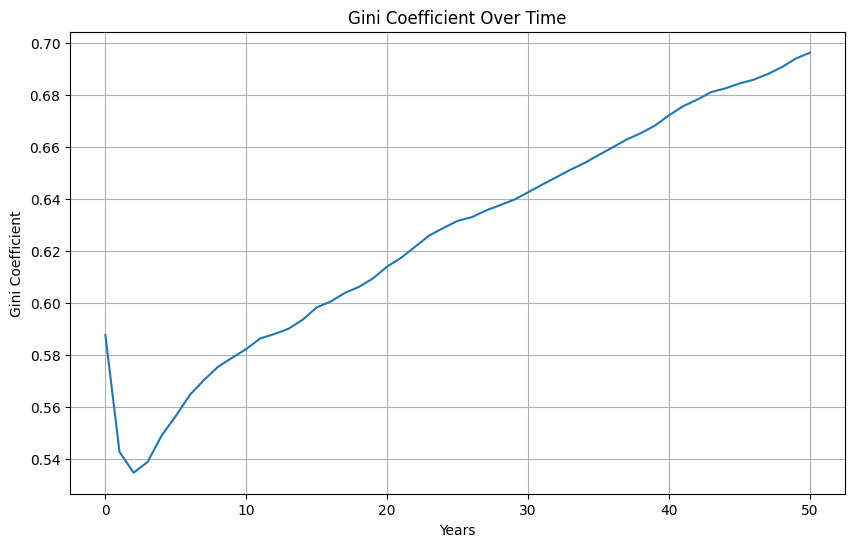

In [18]:
# Cell 6: Visualize Gini Coefficient Over Time
plt.figure(figsize=(10, 6))
years = np.arange(num_years+1)  # Adjusted to include the initial year
plt.plot(years, gini_indices)
plt.title('Gini Coefficient Over Time')
plt.xlabel('Years')
plt.ylabel('Gini Coefficient')
plt.grid(True)
plt.show()

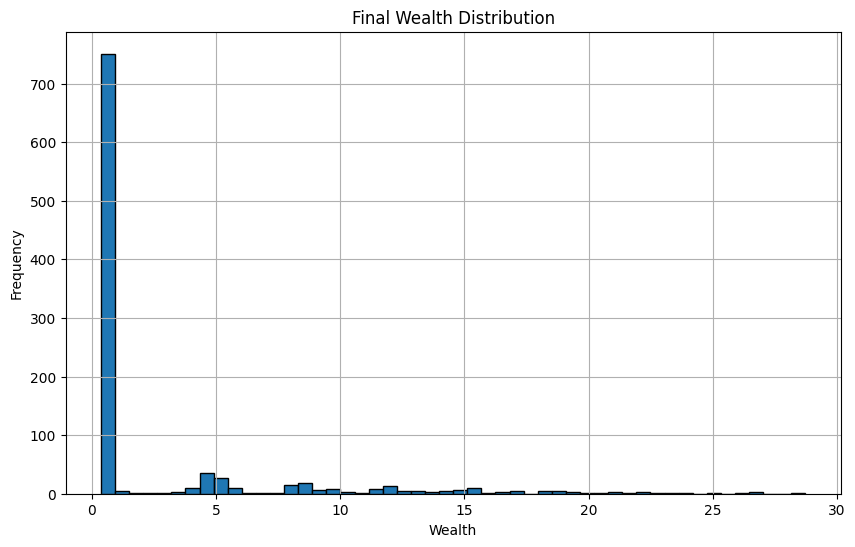

In [19]:
# Cell 7: Visualize Final Wealth Distribution
plt.figure(figsize=(10, 6))
plt.hist(final_wealths, bins=50, edgecolor='black')
plt.title('Final Wealth Distribution')
plt.xlabel('Wealth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

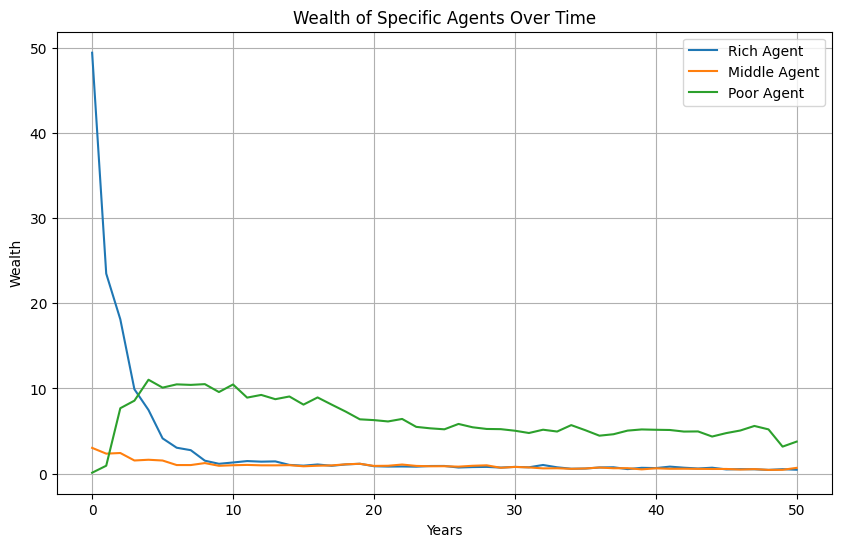

In [21]:
# Cell 8: Visualize Wealth of Rich, Middle, and Poor Agents
plt.figure(figsize=(10, 6))
plt.plot(years, rich_wealth, label='Rich Agent')
plt.plot(years, middle_wealth, label='Middle Agent')
plt.plot(years, poor_wealth, label='Poor Agent')
plt.title('Wealth of Specific Agents Over Time')
plt.xlabel('Years')
plt.ylabel('Wealth')
plt.legend()
plt.grid(True)
plt.show()

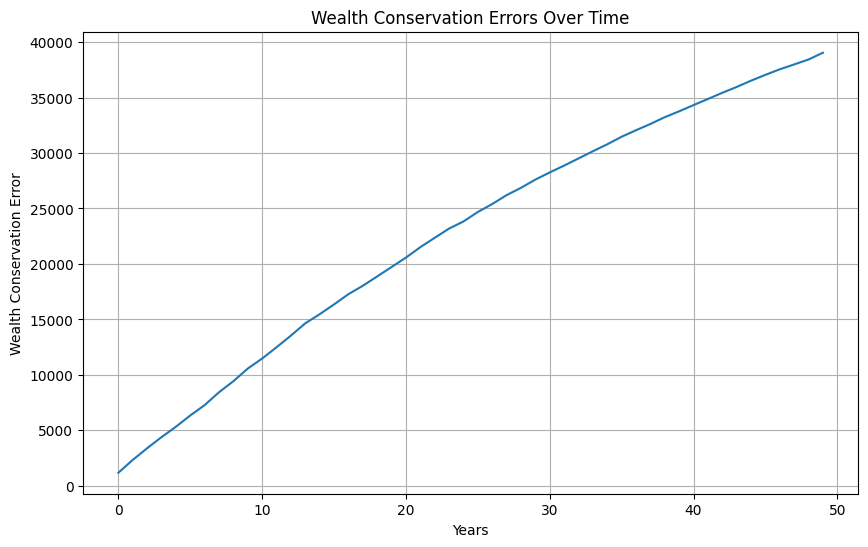

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_years), wealth_conservation_errors)
plt.title('Wealth Conservation Errors Over Time')
plt.xlabel('Years')
plt.ylabel('Wealth Conservation Error')
plt.grid(True)
plt.show()

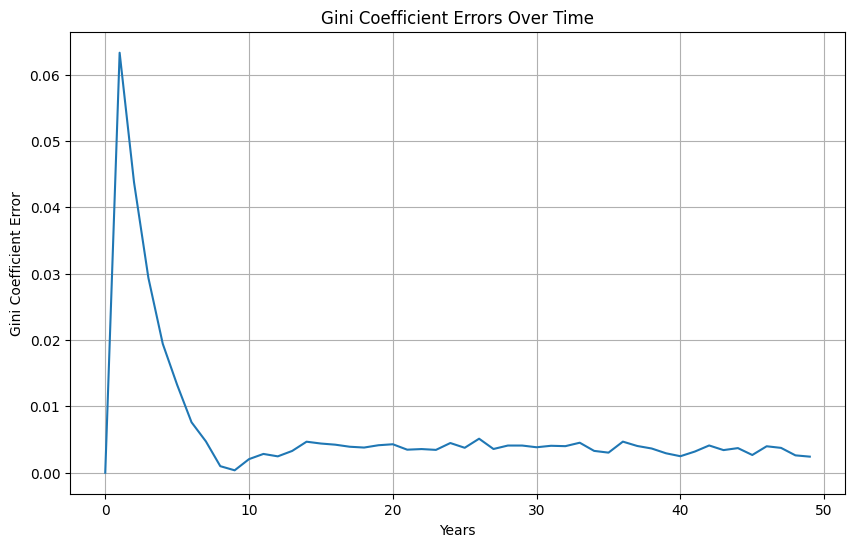

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_years), gini_errors)
plt.title('Gini Coefficient Errors Over Time')
plt.xlabel('Years')
plt.ylabel('Gini Coefficient Error')
plt.grid(True)
plt.show()

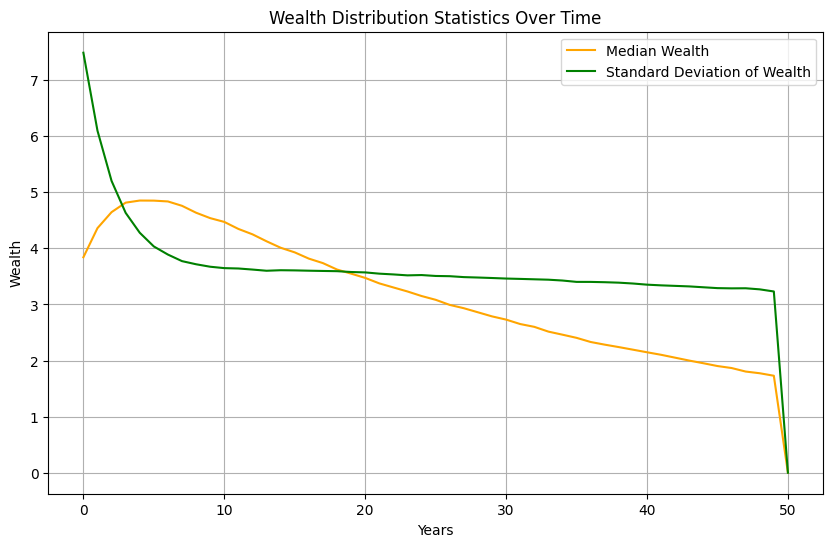

In [11]:
plt.figure(figsize=(10, 6))
years = np.arange(num_years + 1)  # Adjusted to include the initial year
plt.plot(years, median_wealth, label='Median Wealth', color='orange')
plt.plot(years, std_dev_wealth, label='Standard Deviation of Wealth', color='green')
plt.title('Wealth Distribution Statistics Over Time')
plt.xlabel('Years')
plt.ylabel('Wealth')
plt.legend()
plt.grid(True)
plt.show()